# Run cells from AllenDB

In [ ]:
!git clone https://github.com/cyneuro/single-cell-tuning.git

In [ ]:
%cd single-cell-tuning/Segregated/

In [2]:
# If running in Colab
!pip install --upgrade pip
!pip install --quiet allensdk neuron
!git clone -b release_candidate https://github.com/V-Marco/ACT.git

Cloning into 'ACT'...
remote: Enumerating objects: 4392, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 4392 (delta 200), reused 265 (delta 102), pack-reused 3973 (from 1)
Receiving objects: 100% (4392/4392), 153.20 MiB | 41.61 MiB/s, done.
Resolving deltas: 100% (2018/2018), done.


In [4]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 162.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 195.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 208.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 207.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 158.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 164.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 200.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 199.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 206.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 200.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 198.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [6]:
# Compile the modfiles
!nrnivmodl modfiles > /dev/null 2>&1

## Build the cell

**NOTE:** Control the soma area in the `build_cell` function below.

In [7]:
def build_cell():
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h

    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)

    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()

    # To match PP
    h.soma[0].diam = h.soma[0].diam * 0.6

    return h

def set_simulation(stim_amp):
    h = build_cell()

    stim = h.IClamp(h.soma[0](0.5))
    stim.amp = stim_amp
    stim.delay = 300.0
    stim.dur = 1000
    h.tstop = 1500.0
    h.dt = 0.1
    h.steps_per_ms = 1 / h.dt

    return h, stim

## Morphology

In [8]:
h = build_cell()

--No graphics will be displayed.


warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [9]:
print(f"Soma area: {h.soma[0](0.5).area()}")
print(f"Soma diam: {h.soma[0].diam}")
print(f"Soma L: {h.soma[0].L}")

Soma area: 302.1793846159231
Soma diam: 7.596839904785156
Soma L: 12.661407470703125


## Passive properties

In [10]:
computed_soma_area = 5.036323076932052e-06 # (cm2)

user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)

ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


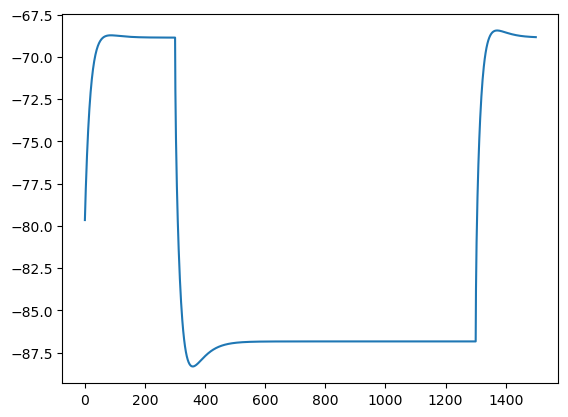

In [11]:
h, stim = set_simulation(-0.1)
v = h.Vector().record(h.soma[0](0.5)._ref_v)
h.finitialize()
h.run()
plt.plot(v.as_numpy()[::10])

In [291]:
print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, 300, 1290, -0.1))
print(f"V-rest: {v.as_numpy()[300]}")

GettablePassiveProperties(R_in=194.7525139028619, tau1=11.700000000000001, tau2=63.0, sag_ratio=0.07619332016214711)
V-rest: -70.35248813302549


## FI-Curve

In [282]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [286]:
frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for amp in amps:
    h, stim = set_simulation(amp)
    v = h.Vector().record(h.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(count_voltage_events(np.arange(len(v.as_numpy()))[2990:13010], v.as_numpy()[2990:13010]))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root

In [287]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 8
0.1: 29
0.15: 47
0.2: 59
0.25: 71
0.3: 73


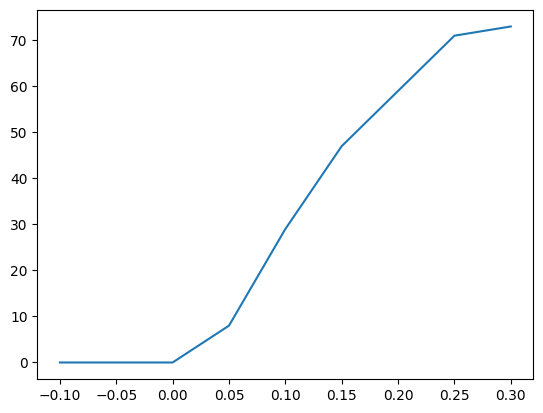

In [ ]:
# Change NaP to shift rheobase
# Change SK to change slope
plt.plot(amps, frequenies)

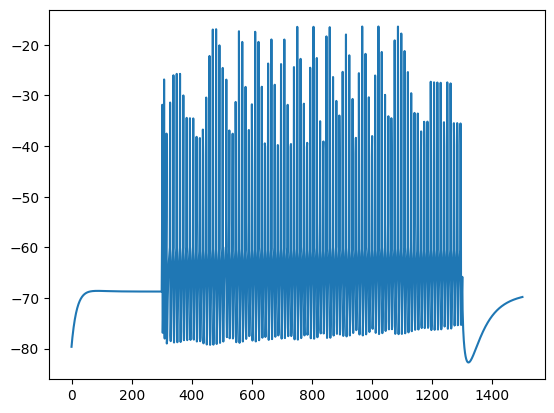

In [266]:
plt.plot(v.as_numpy()[::10])